# 2 Dimensional Scans
Outputting the graphs of the data collected by running the robot :) This data is just for viewing purposes, there is a separate notebook for testing the pathfinder modules.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

from mpl_toolkits import mplot3d
%matplotlib inline

#TODO not urgent, but the 2D scans notebook has not
# been update to reflect the new numpy schema of the
# point data. Should work on that. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
path = os.path.abspath('..\\')
print("Available test files:")
file_itr = 0
while os.path.exists(path + "\\Scans\\test_%s.json" % file_itr):
    print("\t\\Scans\\test_%s.json" % file_itr)
    file_itr +=1
file_itr = 0
while os.path.exists(path + "\\Debugging Scripts\\test_%s.json" % file_itr):
    print("\t\\Debugging Scripts\\test_%s.json" % file_itr)
    file_itr +=1


Available test files:
	\Scans\test_0.json
	\Scans\test_1.json
	\Scans\test_2.json
	\Scans\test_3.json
	\Scans\test_4.json
	\Scans\test_5.json
	\Scans\test_6.json
	\Scans\test_7.json
	\Scans\test_8.json
	\Scans\test_9.json
	\Scans\test_10.json
	\Scans\test_11.json
	\Scans\test_12.json
	\Scans\test_13.json
	\Scans\test_14.json
	\Scans\test_15.json
	\Scans\test_16.json
	\Scans\test_17.json
	\Scans\test_18.json
	\Scans\test_19.json
	\Scans\test_20.json
	\Scans\test_21.json
	\Scans\test_22.json
	\Scans\test_23.json


In [47]:
debug_mode = True
save_figs = False
file_no = 23

if save_figs:
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    })
else:
    plt.rcParams['figure.dpi'] = 200

In [48]:
# current_file = r"\Debugging Scripts\test_%s.json" % file_no
current_file = r"\Scans\test_%s.json" % file_no
path = os.path.abspath('..\\') + current_file

if debug_mode:
    print(path)

with open(path, 'r') as infile:
    json_data = json.load(infile)

# print(json_data)

r_o_m = json_data["range of motion"]
resolution = json_data["resolution"]
points = json_data["points"]
max_point = json_data["max_point"]

if debug_mode:
    for i in json_data.keys():
        if i != "points":
            print(f"{i}: {json_data[i]}")
        else:
            print(f"{i}: {json_data[i][0]}")

c:\Users\BAIL_SD_OCE\Documents\COBOT_Code\COBOT-Transducer-Control-Code\Scans\test_23.json
range of motion: {'X': [0, 0], 'Y': [0, 0], 'Z': [-4, 4], 'Rx': [-10, 10], 'Ry': [0, 0], 'Rz': [0, 0]}
resolution: [0.6, 2]
max_point: [0.0, 0.0, -1.5384615384615383, 6.0, 0.0, 0.0, 0.98867]
points: [-1.5384615384615383, -8.0, 0.32961]
notes: No notes passed from setup.
Ellipsoidal version of a fullscan module, scans an n-ellipse around the origin at a fixed resolution.
	Range of motion: {'X': [0, 0], 'Y': [0, 0], 'Z': [-4, 4], 'Rx': [-10, 10], 'Ry': [0, 0], 'Rz': [0, 0]}
	Resolution: (0.6, 2)
	Highest magnitude found: [ 0.00  0.00 -1.54  6.00  0.00  0.00  0.99]
active_ROM: ['Z', 'Rx']


In [49]:
np_all = np.array(points)
active_rom = json_data["active_ROM"]
cols = active_rom.copy()
cols.append("mag")
dat = pd.DataFrame(data=np_all, columns=cols)

mp = dat.loc[dat['mag'].idxmax()]

if debug_mode:
    print(mp)
    print(dat.head())
    print(dat.shape)

Z     -1.538462
Rx     6.000000
mag    0.988670
Name: 81, dtype: float64
          Z   Rx      mag
0 -1.538462 -8.0  0.32961
1 -0.923077 -8.0 -0.28929
2 -0.307692 -8.0 -0.41576
3  0.307692 -8.0 -0.49999
4  0.923077 -8.0  0.28248
(97, 3)


Maximum magnitude:  0.98867
Minimum magnitude: -0.49999
Median magnitude: 0.3072


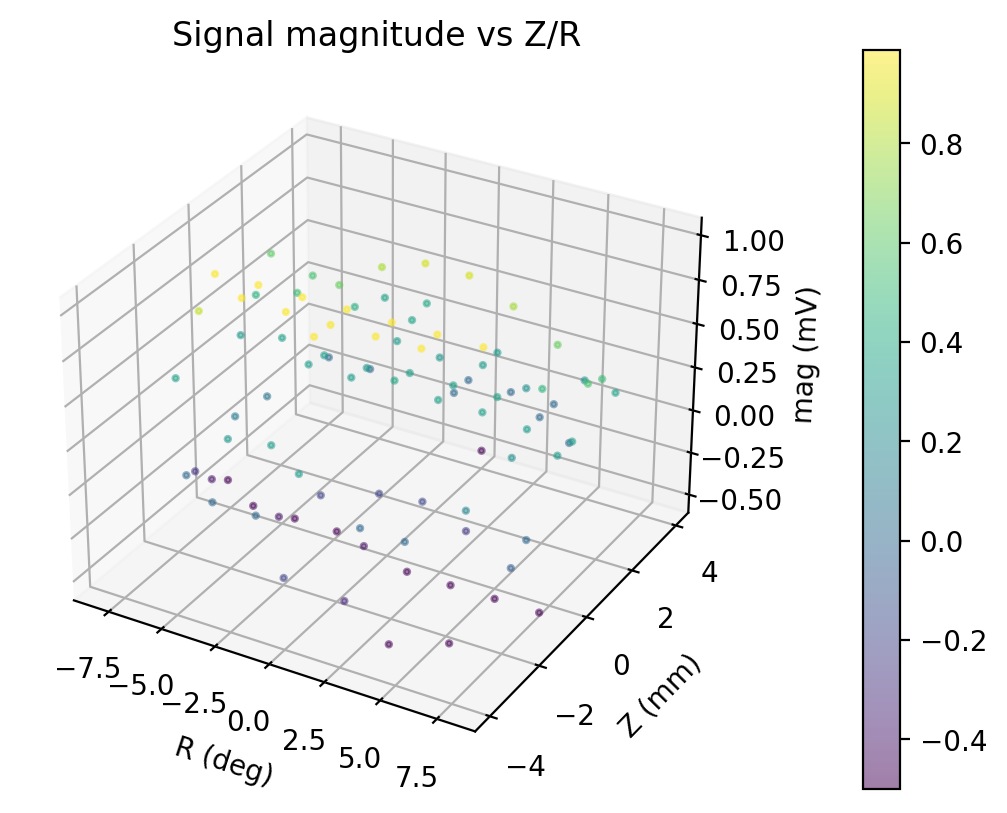

0.98867


In [50]:
ax = plt.axes(projection='3d')

rotational_axis = "Rx"

if debug_mode:
    print(f"Maximum magnitude:  {max(dat['mag'])}")
    print(f"Minimum magnitude: {min(dat['mag'])}")
    print(f"Median magnitude: {np.median(dat['mag'])}")

med = np.median(dat['mag'])
# dat2 = dat[np.all([dat['mag'] > med*1.3, dat['Ry'] > 5],axis=0)]
dat2 = dat[dat['mag'] > med*1.3]

# fig = ax.scatter(dat2['Rx'], dat2['Ry'], dat2['Z'], c=dat2['mag'], cmap='viridis', alpha=0.1,s=4)
fig = ax.scatter(dat[rotational_axis], dat['Z'], dat['mag'], c=dat['mag'], cmap='viridis', alpha=0.5,s=4)

ax.set_xlabel("R (deg)")
ax.set_ylabel("Z (mm)")
ax.set_zlabel("mag (mV)")
ax.set_title("Signal magnitude vs Z/R")

plt.colorbar(fig, pad=0.13)
if save_figs:
    plt.savefig("figures\\2D_fullscan_render_test_%s.jpg" % file_no, dpi=400)
plt.show()

print(max(dat['mag']))


In [51]:
# "mps" stands for "max points," or all the points in Rx/Ry space that occur at the max
# value of Z, rotated for each of the other dimensions
# mp = max_point[0]

zmps = dat[dat['Z'] == mp['Z']].reset_index(drop=True)
Rmps = dat[dat[rotational_axis] == mp[rotational_axis]].reset_index(drop=True)

if debug_mode:
    print(f"Active range of motion: {active_rom}")
    print(f"Shape of points array: {dat.shape}")
    print(f"Tenth point_mag item (representative): {np_all[10]}")
    print(f"Testing the Z-max-points array:\n{zmps.head(4)}\n(Should be all the same as in the maxpoint)")
    print(f"Maximum point: {mp}")

Active range of motion: ['Z', 'Rx']
Shape of points array: (97, 3)
Tenth point_mag item (representative): [-0.92307692 -6.          0.10538   ]
Testing the Z-max-points array:
          Z   Rx      mag
0 -1.538462 -8.0  0.32961
1 -1.538462 -6.0  0.98248
2 -1.538462 -4.0  0.98766
3 -1.538462 -2.0  0.98758
(Should be all the same as in the maxpoint)
Maximum point: Z     -1.538462
Rx     6.000000
mag    0.988670
Name: 81, dtype: float64


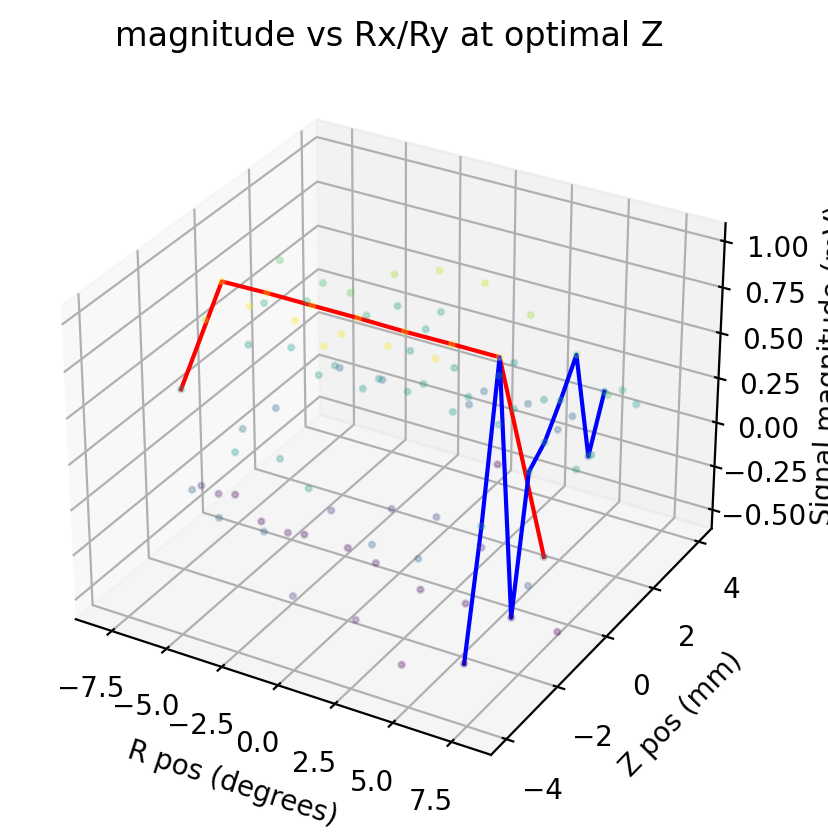

In [52]:
# fig2 = plt.figure(figsize=(14,4), constrained_layout=True)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

# tax = fig2.add_subplot(1,3,1, projection='3d')
tax = plt.axes(projection='3d')
tax.scatter3D(dat[rotational_axis], dat['Z'], dat['mag'], c=dat['mag'], cmap='viridis', alpha=0.25,s=4)
tax.plot3D(zmps[rotational_axis], zmps['Z'], zmps['mag'],c='r')
tax.plot3D(Rmps[rotational_axis], Rmps['Z'], Rmps['mag'],c='b')
tax.set_title("magnitude vs Rx/Ry at optimal Z")
tax.set_xlabel("R pos (degrees)")
tax.set_ylabel("Z pos (mm)")
tax.set_zlabel("Signal magnitude (mV)")

plt.show()

if save_figs:
    plt.savefig("figures\\2D_fullscan_trace_%s.jpg" % file_no, dpi=400)
plt.show()

KeyError: "None of [Int64Index([16, 60], dtype='int64')] are in the [index]"

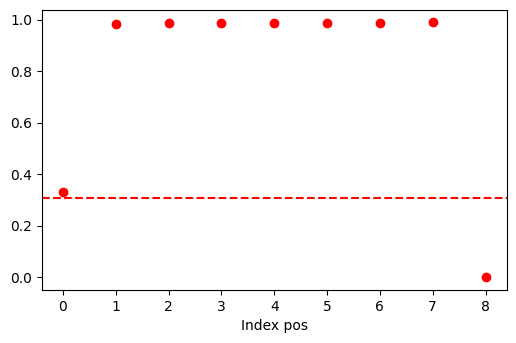

In [53]:
fig3 = plt.figure(figsize=(6,8), dpi=100)
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.8, 
#                     hspace=0.4)

# interpolation_windows = {'Ry': [27,77], 'Z': [11,20]} # Best for scan_11.json
interpolation_windows = {rotational_axis: [16,60], 'Z': [22,48]} # Best for scan_10.json

tax = fig3.add_subplot(211)
# tax.scatter(zmps['Ry'],zmps['mag'], c='r')
# tax.set_xlabel("R pos (deg)")

tax.scatter(np.arange(0,zmps[rotational_axis].size), zmps['mag'], c='r')
tax.set_xlabel("Index pos")

tax.axhline(np.median(dat['mag']), c='r',ls='--')
# tax.axhline(np.median(dat['mag']), c='r',ls='--')
# a = [16,64]
a = interpolation_windows[rotational_axis]
tax.scatter(a,zmps['mag'][a], c='b', marker='*')
tax.set_title("magnitude vs R at optimal Z")
tax.set_ylabel("Magnitude (mV)")


tax = fig3.add_subplot(212)
# tax.scatter(Rmps['Z'],Rmps['mag'], c='b')
# tax.set_ylabel("Magnitude (mV)")

tax.scatter(np.arange(0,Rmps['Z'].size), Rmps['mag'], c='b')
tax.set_xlabel("Index pos")

tax.axhline(np.median(dat['mag']), c='b',ls='--')
# a = [25,45]
a=interpolation_windows['Z']
tax.scatter(a,Rmps['mag'][a], c='r', marker='*')

tax.set_title("magnitude vs Z at optimal R")
tax.set_xlabel("Z pos (mm)")

fig3.tight_layout()

if save_figs:
    fig3.savefig("figures\\2D_degree_isolation_%s.jpg" % file_no, dpi=400)
plt.show()

In [ ]:
from fit_funcs import *


def polynomial_2(x, a, b, c):
    return (a*(x**2)) + (b*x) + c

funcs = [gauss,rational_2,polynomial_2,inv_absolute]
# funcs = [gauss,gauss_plus,rational_2,polynomial_2]

None
[6.28754938e+02 1.82356031e-02 4.19542368e-01 3.93603134e+01]


TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

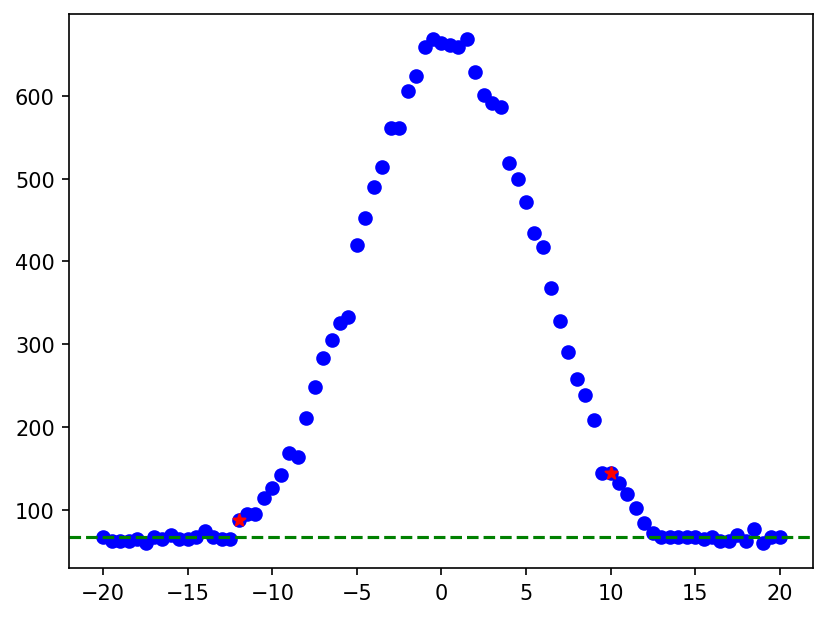

In [ ]:
fig4 = plt.axes()
fig4.get_figure().dpi=150

t = {'Z': {'data': Rmps, 'color1': 'r', 'noise': np.median(dat['mag']), 'color2':'g', \
    'header':'magnitude vs Z at optimal Rx/Ry', 'x-axis': "Z pos (mm)"}, \
    'Ry': {'data': zmps, 'color1':'b', 'noise': np.median(dat['mag']), 'color2':'r', \
    'header':'magnitude vs R at optimal Z', 'x-axis':"Ry ang (deg)"}}

b = "Ry"
a = interpolation_windows[b]

fig4.scatter(t[b]['data'][b],t[b]['data']['mag'], c=t[b]['color1'])

fig4.scatter(t[b]['data'][b][a],t[b]['data']['mag'][a], c=t[b]['color2'], marker='*')
fig4.axhline(t[b]['noise'], c='g',ls='--')

# x = np.linspace(t[b][0].reset_index()[b][a[0]],t[b][0].reset_index()[b][a[1]])
x = np.linspace(min(t[b]['data'][b]),max(t[b]['data'][b]),500)

x_data = t[b]['data'][b][a[0]:a[1]]
y_data = t[b]['data']['mag'][a[0]:a[1]]

for fun in funcs:
    popt, pcov = curve_fit(fun, x_data, y_data,maxfev = 5000)
    if debug_mode:
        print(fun.__doc__)
        print(popt)
    r2 = r_squared(fun, popt, x_data, y_data)
    if r2 > 0.6:
        fig4.plot(x, fun(x, *popt), label=fun.__doc__ + f"\n R2={r2:0.3f}")


x_data = t[b]['data'][b]
y_data = t[b]['data']['mag']

fig4.set_title(t[b]['header'])
fig4.set_xlabel(t[b]['x-axis'])
fig4.set_ylabel("Magnitude (mV)")
fig4.legend(prop={'size':6})
fig4.set_ybound([0, t[b]['data']['mag'].max() * 1.2])

if save_figs:
    fig4.get_figure().savefig(f"figures\\2D_{b}_axis_funcs_{file_no}.jpg", dpi=400)

In [ ]:
a = -1 - 1j
b = -1 + 1j

a*b
(1+1j)*(1-1j)

(2+0j)